<a href="https://colab.research.google.com/github/ejrtks1020/Computer_Vision_Project/blob/main/Face-Mask-Detection/Face_Mask_Detection_Training_(RetinaNet).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip uninstall opencv-python-headless==4.5.5.62 
!pip install opencv-python-headless==4.1.2.30

Found existing installation: opencv-python-headless 4.1.2.30
Uninstalling opencv-python-headless-4.1.2.30:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/cv2/*
    /usr/local/lib/python3.7/dist-packages/opencv_python_headless-4.1.2.30.dist-info/*
  Would not remove (might be manually added):
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtCore-bbdab771.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtGui-903938cd.so.4.8.7
    /usr/local/lib/python3.7/dist-packages/cv2/.libs/libQtTest-1183da5d.so.4.8.7
Proceed (y/n)? y
  Successfully uninstalled opencv-python-headless-4.1.2.30
  Using cached opencv_python_headless-4.1.2.30-cp37-cp37m-manylinux1_x86_64.whl (21.8 MB)


In [ ]:
!pip install --upgrade albumentations

#1.데이터셋 다운로드

In [ ]:
import os

os.environ['KAGGLE_USERNAME'] = ''
os.environ['KAGGLE_KEY'] = ''

In [ ]:
!kaggle datasets download -d andrewmvd/face-mask-detection

 99% 394M/398M [00:03<00:00, 135MB/s]
100% 398M/398M [00:03<00:00, 133MB/s]


In [ ]:
!mkdir mask_dataset

In [ ]:
!unzip face-mask-detection.zip -d mask_dataset

In [ ]:
!cat "/content/mask_dataset/annotations/maksssksksss2.xml"


<annotation>
    <folder>images</folder>
    <filename>maksssksksss2.png</filename>
    <size>
        <width>400</width>
        <height>290</height>
        <depth>3</depth>
    </size>
    <segmented>0</segmented>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>68</xmin>
            <ymin>42</ymin>
            <xmax>105</xmax>
            <ymax>69</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>
        <occluded>0</occluded>
        <difficult>0</difficult>
        <bndbox>
            <xmin>154</xmin>
            <ymin>47</ymin>
            <xmax>178</xmax>
            <ymax>74</ymax>
        </bndbox>
    </object>
    <object>
        <name>with_mask</name>
        <pose>Unspecified</pose>
        <truncated>0</truncated>

* 이미지 수 : 853 개
* 클래스 종류 : 3

    With mask
    
    Without mask
    
    Mask worn incorrectly

#2. 바운딩 박스 도식화

In [ ]:
import cv2
import os
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import matplotlib.patches as patches
import torch
from bs4 import BeautifulSoup

In [ ]:
img_list = sorted(glob.glob('mask_dataset/images/*'))
annot_list = sorted(glob.glob('mask_dataset/annotations/*'))

In [ ]:
print(len(img_list))
print(len(annot_list))

853
853


In [ ]:
# 파일명 확인
print(img_list[:10])
print(annot_list[:10])

['mask_dataset/images/maksssksksss0.png', 'mask_dataset/images/maksssksksss1.png', 'mask_dataset/images/maksssksksss10.png', 'mask_dataset/images/maksssksksss100.png', 'mask_dataset/images/maksssksksss101.png', 'mask_dataset/images/maksssksksss102.png', 'mask_dataset/images/maksssksksss103.png', 'mask_dataset/images/maksssksksss104.png', 'mask_dataset/images/maksssksksss105.png', 'mask_dataset/images/maksssksksss106.png']
['mask_dataset/annotations/maksssksksss0.xml', 'mask_dataset/annotations/maksssksksss1.xml', 'mask_dataset/annotations/maksssksksss10.xml', 'mask_dataset/annotations/maksssksksss100.xml', 'mask_dataset/annotations/maksssksksss101.xml', 'mask_dataset/annotations/maksssksksss102.xml', 'mask_dataset/annotations/maksssksksss103.xml', 'mask_dataset/annotations/maksssksksss104.xml', 'mask_dataset/annotations/maksssksksss105.xml', 'mask_dataset/annotations/maksssksksss106.xml']


In [ ]:
def generate_box(obj):
  xmin = float(obj.find('xmin').text)
  ymin = float(obj.find('ymin').text)
  xmax = float(obj.find('xmax').text)
  ymax = float(obj.find('ymax').text)
  return [xmin, ymin, xmax, ymax]

def generate_label(obj):
  if obj.find('name').text == 'with_mask':
    return 1
  elif obj.find('name').text == 'mask_weared_incorrect':
    return 2
  return 0

def generate_target(file):
  with open(file) as f:
    data = f.read()
    soup = BeautifulSoup(data, 'html.parser')
    objects = soup.find_all('object')

    num_objs = len(objects)

    boxes = []
    labels = []
    #각 오브젝트에서 바운딩박스와 label 추출
    for i in objects:
      boxes.append(generate_box(i))
      labels.append(generate_label(i))
    
    boxes = torch.as_tensor(boxes, dtype = torch.float32) # 추후 딥러닝 모델학습을 위한 tensor간 연산을 위해 tensor로 변환
    labels = torch.as_tensor(labels, dtype = torch.int64)

    target = {}
    target["boxes"] = boxes
    target["labels"] = labels
    return target

In [ ]:
generate_target("/content/mask_dataset/annotations/maksssksksss2.xml")

{'boxes': tensor([[ 68.,  42., 105.,  69.],
         [154.,  47., 178.,  74.],
         [238.,  34., 262.,  69.],
         [333.,  31., 366.,  65.]]), 'labels': tensor([1, 1, 1, 2])}

In [ ]:
def plot_image(img_path, annotation):
  img = mpimg.imread(img_path)

  fig, ax = plt.subplots(1)
  ax.imshow(img)

  for idx in range(len(annotation["boxes"])):
    xmin, ymin, xmax, ymax = annotation["boxes"][idx]
    if annotation['labels'][idx] == 0:
      rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth = 1, edgecolor = 'r', facecolor = 'none')
    elif annotation['labels'][idx] == 1:
      rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth = 1, edgecolor = 'g', facecolor = 'none')
    else:
      rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth = 1, edgecolor = 'b', facecolor = 'none')
    ax.add_patch(rect)
  plt.show()

In [ ]:
def plot_image_cv(img_path, annotation):
  img = cv2.imread(img_path)
  plot_img = img.copy()

  for i in range(len(annotation['boxes'])):
    bbox = annotation['boxes'][i]
    left = int(bbox[0])
    top = int(bbox[1])
    right = int(bbox[2])
    bottom = int(bbox[3])
    
    if annotation['labels'][i] == 0:
      color = (0, 0, 255) # red color
      text = 'without_mask'
    elif annotation['labels'][i] == 1:
      color = (0, 255, 0) # green color
      text = 'with_mask'
    else:
      color = (255, 0, 0) # blue color
      text = 'mask_incorrect'
    cv2.rectangle(plot_img, (left, top), (right, bottom), color = color, thickness = 1)

    cv2.putText(plot_img, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4,color = color, thickness = 1)
  
  img_rgb = cv2.cvtColor(plot_img, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (10, 10))
  plt.imshow(img_rgb)

In [ ]:
img_exam, annot_exam = img_list[0], annot_list[0]

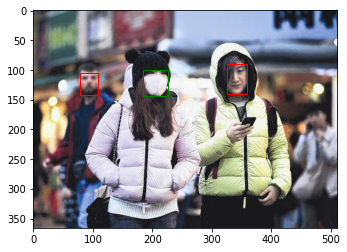

In [ ]:
bbox_label = generate_target(annot_exam)
plot_image(img_exam, bbox_label)

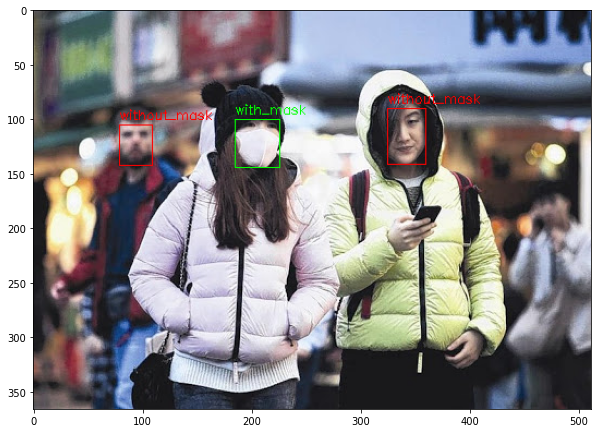

In [ ]:
plot_image_cv(img_exam, bbox_label)

#3. 데이터 전처리

##3.1 Augmentation

In [ ]:
# torch.Tensor로 변환된 이미지를 시각화 하는 함수
def plot_image_from_output(img, annotation):
  # PyTorch는 이미지를 [channels, height, width]로 표현하기 때문에 matplotlib에서 받는 순서로 변환(channel last)
  img = img.permute(1, 2, 0)
  
  fig, ax = plt.subplots(1)
  ax.imshow(img)

  for idx in range(len(annotation["boxes"])):
    xmin, ymin, xmax, ymax = annotation["boxes"][idx]
    if annotation['labels'][idx] == 0:
      rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth = 1, edgecolor = 'r', facecolor = 'none')
    elif annotation['labels'][idx] == 1:
      rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth = 1, edgecolor = 'g', facecolor = 'none')
    else:
      rect = patches.Rectangle((xmin, ymin), (xmax-xmin), (ymax-ymin), linewidth = 1, edgecolor = 'b', facecolor = 'none')
    ax.add_patch(rect)
  plt.show()

In [ ]:
def plot_image_from_output_cv(img, annotation):
  img = img.permute(1, 2, 0)
  img2 = np.array(img.numpy() * 255, dtype = np.uint8)
  img_bgr = cv2.cvtColor(img2, cv2.COLOR_RGB2BGR)

  for i in range(len(annotation['boxes'])):
    bbox = annotation['boxes'][i]
    left = int(bbox[0])
    top = int(bbox[1])
    right = int(bbox[2])
    bottom = int(bbox[3])
    
    if annotation['labels'][i] == 0:
      color = (0, 0, 255) # red color
      text = 'without_mask'
    elif annotation['labels'][i] == 1:
      color = (0, 255, 0) # green color
      text = 'with_mask'
    else:
      color = (255, 0, 0) # blue color
      text = 'mask_incorrect'
    cv2.rectangle(img_bgr, (left, top), (right, bottom), color = color, thickness = 1)

    cv2.putText(img_bgr, text, (left, top - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4,color = color, thickness = 1)
  img_rgb = cv2.cvtColor(img_bgr, cv2.COLOR_BGR2RGB)
  plt.figure(figsize = (10, 10))
  plt.imshow(img_rgb)

###3.1.1. Torchvision Transforms

In [ ]:
from PIL import Image
import numpy as np
import time
import torchvision
from torch.utils.data import Dataset
from torchvision import transforms
import albumentations
import albumentations.pytorch
import random

In [ ]:
class TorchVisionMaskDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join("mask_dataset/test_annotations/", file_label)
    else:
      label_path = os.path.join("mask_dataset/annotations/", file_label)

    img = Image.open(img_path).convert("RGB")
    target = generate_target(label_path)
    start_t = time.time()
    if self.transform:
      img = self.transform(img)
    total_time = (time.time() - start_t)
    return img, target, total_time

In [ ]:
torchvision_transform = transforms.Compose([
                                            transforms.Resize((300,300)),
                                            transforms.RandomCrop(224),
                                            #밝기, 대비, 채도(saturation), 색조(hue) 무작위 변화
                                            transforms.ColorJitter(brightness=0.2, contrast = 0.2, saturation = 0.2, hue = 0.2),
                                            transforms.RandomHorizontalFlip(p = 1),
                                            transforms.ToTensor()
])
only_totensor = transforms.Compose([transforms.ToTensor()])
# Augmentation을 적용한 데이터셋
torchvision_dataset = TorchVisionMaskDataset(path = 'mask_dataset/images/',
                                             transform = torchvision_transform)

# ToTensor만 적용한 데이터셋
torchvision_dataset_no_transform = TorchVisionMaskDataset(path = 'mask_dataset/images/',
                                                          transform = only_totensor)

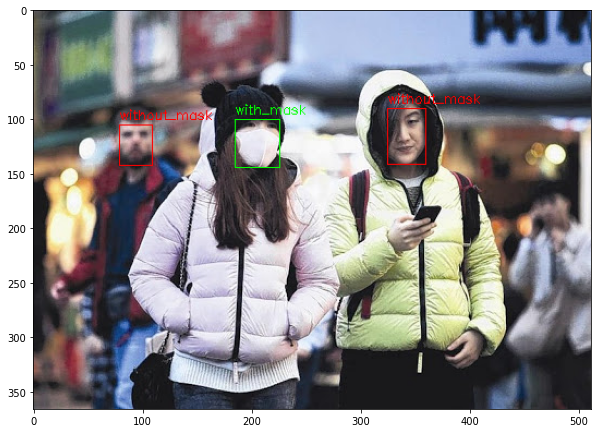

In [ ]:
# tansform 적용 전
img, annot, transform_time = torchvision_dataset_no_transform[0]
plot_image_from_output_cv(img, annot)

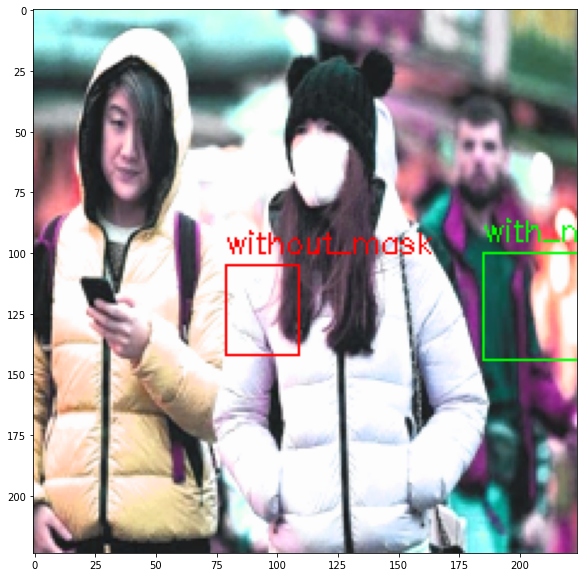

In [ ]:
# transform 적용 후
img, annot, transform_time = torchvision_dataset[0]
plot_image_from_output_cv(img, annot)

* 이미지는 변환이 이루어졌지만 바운딩 박스는 이미지에서 위치가 어긋남
* torchvision.transform에서는 이미지값에 대한 augmentation만 진행되며 라벨 값은 변환되지 않음.

In [ ]:
# 이미지 변환 시간 측정
total_time = 0
for i in range(100):
  _, __, transform_time = torchvision_dataset[0]
  total_time += transform_time

print(f"torchvision time: {total_time*10} ms")

torchvision time: 9.503419399261475 ms


torchvision의 이미지 변환 모듈은 100번 변환하는데 10ms ~ 11ms정도 소요된다.

###3.1.2. Albumentations

In [ ]:
class AlbumentationsDataset(Dataset):
  def __init__(self, path, transform = None):
    self.path = path
    self.imgs = list(sorted(os.listdir(self.path)))
    self.transform = transform

  def __len__(self):
    return len(self.imgs)

  def __getitem__(self, idx):
    file_image = self.imgs[idx]
    file_label = self.imgs[idx][:-3] + 'xml'
    img_path = os.path.join(self.path, file_image)

    if 'test' in self.path:
      label_path = os.path.join("mask_dataset/test_annotations/", file_label)
    else:
      label_path = os.path.join("mask_dataset/annotations/", file_label)

    image = cv2.imread(img_path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    target = generate_target(label_path)
    start_t = time.time()
    if self.transform:
      augmented = self.transform(image = image)
      image = augmented['image']
    total_time = (time.time() - start_t)
    return image, target, total_time

In [ ]:
albumentations_transform = albumentations.Compose([
                                                   albumentations.Resize(300, 300),
                                                   albumentations.RandomCrop(224, 224),
                                                   albumentations.ColorJitter(p = 1),
                                                   albumentations.HorizontalFlip(p = 1),
                                                   albumentations.pytorch.ToTensorV2()
])

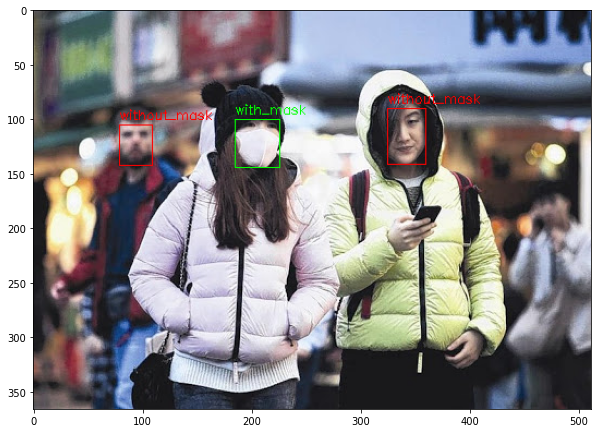

In [ ]:
#변경 전
img, annot, total_time = torchvision_dataset_no_transform[0]
plot_image_from_output_cv(img, annot)

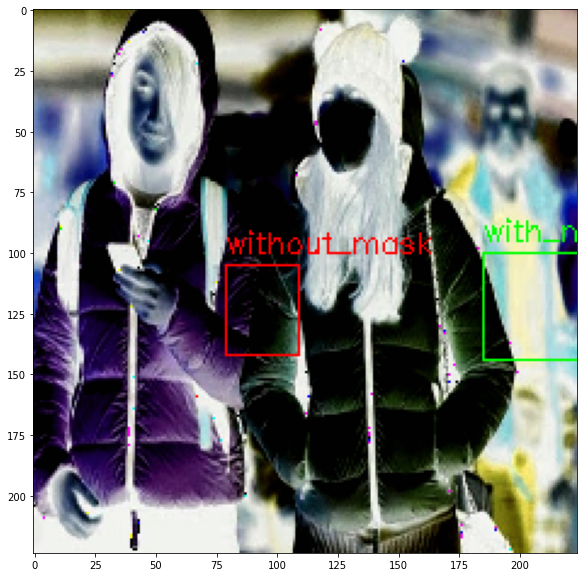

In [ ]:
#변경 후
albumentations_dataset = AlbumentationsDataset(path = "/content/mask_dataset/images", transform = albumentations_transform)
img, annot, tansform_time = albumentations_dataset[0]
plot_image_from_output_cv(img, annot)

torchvision.transform과 마찬가지모 이미지 변환은 일어났지만 바운딩 박스에 대한 변환은 적용되지않았다.

In [ ]:
# 속도 측정을 위해 albumentation 100번 적용
total_time = 0
for i in range(100):
  sample, _, transform_time = albumentations_dataset[0]
  total_time += transform_time

print("Total time albumentations time / sample: ", total_time * 10)

Total time albumentations time / sample:  2.3540711402893066


이미지 변환을 100번 수행하는데 2.5ms 정도가 소요된 것을 확인할 수 있다.

torchvision.transforms와 비교했을때 약 4배 정도 빠른 것을 알 수 있다.

### 3.1.3. 확률 기반 Augmentation 조합

In [ ]:
albumentations_transform_oneof = albumentations.Compose([
                                                        albumentations.Resize(300, 300),
                                                        albumentations.RandomCrop(224, 224),
                                                        albumentations.OneOf([
                                                                              albumentations.HorizontalFlip(p = 1),
                                                                              albumentations.RandomRotate90(p = 1),
                                                                              albumentations.VerticalFlip(p = 1)
                                                        ], p = 1),
                                                        albumentations.OneOf([
                                                                              albumentations.MotionBlur(p = 1),
                                                                              albumentations.OpticalDistortion(p = 1),
                                                                              albumentations.GaussNoise(p = 1)
                                                        ], p = 1),
                                                        albumentations.pytorch.ToTensorV2()
])

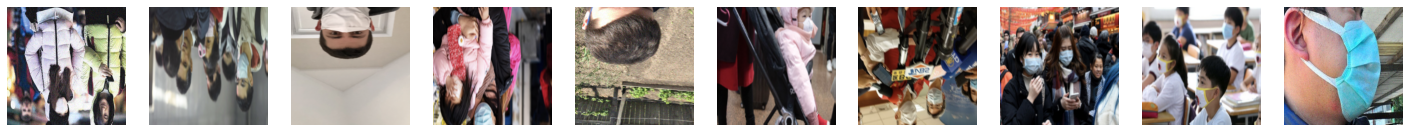

In [ ]:
albumentations_dataset_oneof = AlbumentationsDataset(path = '/content/mask_dataset/images',
                                                     transform = albumentations_transform_oneof)

num_samples = 10
fig, ax = plt.subplots(1, num_samples, figsize = (25, 5))
for i in range(num_samples):
  img, annot, _ = albumentations_dataset_oneof[i]
  ax[i].imshow(transforms.ToPILImage()(img))
  ax[i].axis('off')

##3.2. 바운딩 박스 Augmentation

In [ ]:
class BboxAugmentationDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("mask_dataset/test_annotations/", file_label)
        else:
            label_path = os.path.join("mask_dataset/annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        if self.transform:
            transformed = self.transform(image = image, bboxes = target['boxes'], labels = target['labels'])
            image = transformed['image']
            target = {'boxes':transformed['bboxes'], 'labels':transformed['labels']}
        
            
        return image, target

Face mask Detection 데이터 셋은 바운딩 박스 표기법이 xmin, ymin, xmax, ymax이므로 pascal_voc format

In [ ]:
bbox_transform = albumentations.Compose([
        albumentations.HorizontalFlip(p = 1),
        albumentations.Rotate(p = 1),
        albumentations.pytorch.ToTensorV2()],
        bbox_params = albumentations.BboxParams(format = 'pascal_voc', label_fields = ['labels']))

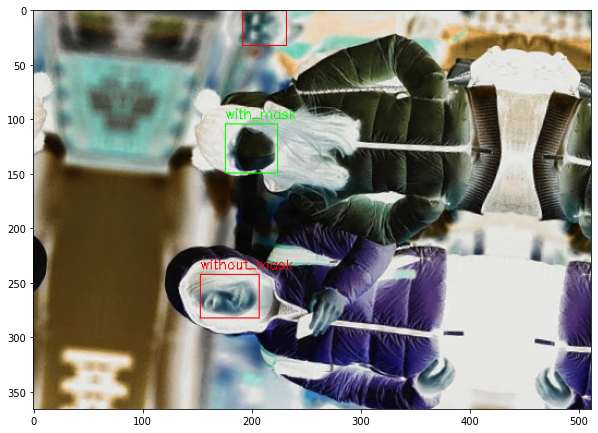

In [ ]:
bbox_transform_dataset = BboxAugmentationDataset(path = '/content/mask_dataset/images',
                                                 transform = bbox_transform)

img, annot = bbox_transform_dataset[0]
plot_image_from_output_cv(img, annot)

##3.3. 데이터 분리

In [ ]:
print(len(os.listdir('mask_dataset/annotations')))
print(len(os.listdir('mask_dataset/images')))

853
853


In [ ]:
%cd mask_dataset
!mkdir test_annotations; mkdir test_images

/content/mask_dataset


In [ ]:
# 전체 데이터셋 개수가 적으므로 8:2 비율로 테스트 데이터를 생성한다
import random
random.seed(1234)
idx = random.sample(range(853), 170)
print(len(idx))
print(idx[:10])

170
[796, 451, 119, 7, 92, 826, 596, 35, 687, 709]


In [ ]:
# 전체 데이터셋 개수가 적으므로 8:2 비율로 테스트 데이터를 생성한다
from sklearn.model_selection import train_test_split
train_idx , test_idx = train_test_split(range(853), test_size = 0.2 ,random_state = 1234)

In [ ]:
len(train_idx), len(test_idx)

(682, 171)

In [ ]:
test_idx[:10]

[620, 534, 348, 148, 230, 277, 322, 503, 501, 89]

In [ ]:
import shutil
for img in np.array(sorted(os.listdir('images')))[test_idx]:
  shutil.move('images/' + img, 'test_images/' + img)

for img in np.array(sorted(os.listdir('annotations')))[test_idx]:
  shutil.move('annotations/' + img, 'test_annotations/' + img)

In [ ]:
#각 디렉토리 파일 개수 확인
print(len(os.listdir('annotations')))
print(len(os.listdir('images')))
print(len(os.listdir('test_images')))
print(len(os.listdir('test_annotations')))

682
682
171
171


In [ ]:
!pwd
%cd ..

/content/mask_dataset
/content


In [ ]:
from tqdm import tqdm
import pandas as pd
from collections import Counter
# 각 클래스별 몇개의 오브젝트가 있는지 확인
def get_num_objects_for_each_class(dataset):
  
  total_labels = []
  for img, annot in tqdm(dataset, position = 0, leave = True):
    total_labels += [int(i) for i in annot['labels']]
  
  return Counter(total_labels)

In [ ]:
train_data = BboxAugmentationDataset(
    path = '/content/mask_dataset/images'
)
test_data = BboxAugmentationDataset(
    path = '/content/mask_dataset/test_images'
)
train_objects = get_num_objects_for_each_class(train_data)
test_objects = get_num_objects_for_each_class(test_data)
print('\n train 데이터에 있는 객체', train_objects)
print('\n test 데이터에 있는 객체', test_objects)

100%|██████████| 171/171 [00:02<00:00, 66.39it/s]


 train 데이터에 있는 객체 Counter({1: 2576, 0: 594, 2: 95})

 test 데이터에 있는 객체 Counter({1: 656, 0: 123, 2: 28})


# 4. RetinaNet

## 4.1. 데이터셋 클래스 정의

In [ ]:
class MaskDataset(Dataset):
    def __init__(self, path, transform=None):
        self.path = path
        self.imgs = list(sorted(os.listdir(self.path)))
        self.transform = transform
        
    def __len__(self):
        return len(self.imgs)

    def __getitem__(self, idx):
        file_image = self.imgs[idx]
        file_label = self.imgs[idx][:-3] + 'xml'
        img_path = os.path.join(self.path, file_image)

        if 'test' in self.path:
            label_path = os.path.join("mask_dataset/test_annotations/", file_label)
        else:
            label_path = os.path.join("mask_dataset/annotations/", file_label)
        
        image = cv2.imread(img_path)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

        target = generate_target(label_path)

        to_tensor = torchvision.transforms.ToTensor()

        if self.transform:
            image , transform_target = self.transform(image = np.array(image), bboxes = np.array(target['boxes']))
            target['boxes'] = torch.as_tensor(transform_target)
        
        # tensor로 변경
        image = to_tensor(image)

        return image, target

def collate_fn(batch):
  return tuple(zip(*batch))

In [ ]:
dataset = MaskDataset('/content/mask_dataset/images/')
test_dataset = MaskDataset('/content/mask_dataset/test_images/')

# 최종적으로 학습용 데이터와 테스트용 데이터를 배치단위로 불러올수 있게 DataLoader함수를 사용
data_loader = torch.utils.data.DataLoader(dataset, batch_size = 4, collate_fn=collate_fn)
test_data_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 2, collate_fn=collate_fn)

In [ ]:
len_train_dataloader = len(data_loader)

In [ ]:
len_train_dataloader # 4(batch size) * 170 + 2 = 682

171

In [ ]:
images, boxes = next(iter(data_loader))

In [ ]:
boxes

({'boxes': tensor([[ 79., 105., 109., 142.],
          [185., 100., 226., 144.],
          [325.,  90., 360., 141.]]), 'labels': tensor([0, 1, 0])},
 {'boxes': tensor([[321.,  34., 354.,  69.],
          [224.,  38., 261.,  73.],
          [299.,  58., 315.,  81.],
          [143.,  74., 174., 115.],
          [ 74.,  69.,  95.,  99.],
          [191.,  67., 221.,  93.],
          [ 21.,  73.,  44.,  93.],
          [369.,  70., 398.,  99.],
          [ 83.,  56., 111.,  89.]]),
  'labels': tensor([1, 1, 1, 1, 1, 1, 1, 1, 0])},
 {'boxes': tensor([[ 98., 267., 194., 383.]]), 'labels': tensor([1])},
 {'boxes': tensor([[189.,  30., 245.,  88.],
          [387.,  54., 400.,  75.],
          [118.,  87., 163., 126.]]), 'labels': tensor([1, 1, 1])})

##4.2. 모델 불러오기

In [ ]:
# RetinaNet은 torchvision 0.8.0 이상에서 제공되므로, torchvision 버전을 맞춰준다.
!pip install torch==1.7.0+cu101 torchvision==0.8.1+cu101 torchaudio==0.7.0 -f https://download.pytorch.org/whl/torch_stable.html

Looking in links: https://download.pytorch.org/whl/torch_stable.html
     |████████████████████████████████| 735.3 MB 26 kB/s 
     |████████████████████████████████| 12.7 MB 26.8 MB/s 
     |████████████████████████████████| 7.6 MB 7.5 MB/s 
  Attempting uninstall: torch
    Found existing installation: torch 1.10.0+cu111
    Uninstalling torch-1.10.0+cu111:
      Successfully uninstalled torch-1.10.0+cu111
  Attempting uninstall: torchvision
    Found existing installation: torchvision 0.11.1+cu111
    Uninstalling torchvision-0.11.1+cu111:
      Successfully uninstalled torchvision-0.11.1+cu111
  Attempting uninstall: torchaudio
    Found existing installation: torchaudio 0.10.0+cu111
    Uninstalling torchaudio-0.10.0+cu111:
      Successfully uninstalled torchaudio-0.10.0+cu111
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchtext 0.11.0 requires torch

In [ ]:
torchvision.__version__

'0.11.1+cu111'

##4.3. 전이 학습(Transfer Learning)

In [ ]:
# 전이학습으로 사용할 pre-trained 모델을 가져온다.
# Feature Extraction layer(backbon)는 사전 학습된 파라미터를, 그 외 레이어는 가중치를 초기화
retina = torchvision.models.detection.retinanet_resnet50_fpn(num_classes = 3, pretrained = False, pretrained_backbone = True)

In [ ]:
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')
num_epochs = 30
retina.to(device)

# parameters
params = [p for p in retina.parameters() if p.requires_grad] # gradient calculation이 필요한 파라미터만 추출

In [ ]:
optimizer = torch.optim.SGD(params, lr=0.001,
                                momentum=0.9, weight_decay=0.0005)

In [ ]:
len(params)

78

In [ ]:
for epoch in range(num_epochs):
  start = time.time()
  retina.train()

  i = 0
  epoch_loss = 0
  for images, targets in data_loader:
    images = list(image.to(device) for image in images)
    targets = [{k : v.to(device) for k , v in t.items()} for t in targets]

    loss_dict = retina(images, targets)
    losses = sum(loss for loss in loss_dict.values())
    i += 1

    optimizer.zero_grad()
    losses.backward()
    optimizer.step()
    epoch_loss += losses
  print(epoch_loss, f'time: {time.time() - start}')

torch.save(retina.state_dict(),f'/content/drive/MyDrive/mask_save/retina_{num_epochs}.pt')

tensor(271.2407, device='cuda:0', grad_fn=<AddBackward0>) time: 267.78046917915344
tensor(173.3432, device='cuda:0', grad_fn=<AddBackward0>) time: 272.5284061431885
tensor(127.1216, device='cuda:0', grad_fn=<AddBackward0>) time: 273.5286967754364
tensor(102.3725, device='cuda:0', grad_fn=<AddBackward0>) time: 273.77511858940125
tensor(91.3359, device='cuda:0', grad_fn=<AddBackward0>) time: 273.23814630508423
tensor(86.1323, device='cuda:0', grad_fn=<AddBackward0>) time: 273.3176155090332
tensor(81.1527, device='cuda:0', grad_fn=<AddBackward0>) time: 273.5379636287689
tensor(73.8763, device='cuda:0', grad_fn=<AddBackward0>) time: 273.67715525627136
tensor(69.3863, device='cuda:0', grad_fn=<AddBackward0>) time: 273.1631875038147
tensor(62.9012, device='cuda:0', grad_fn=<AddBackward0>) time: 272.2498633861542
tensor(57.3703, device='cuda:0', grad_fn=<AddBackward0>) time: 272.41886854171753
tensor(54.6100, device='cuda:0', grad_fn=<AddBackward0>) time: 272.8895926475525
tensor(51.8715, dev